In [91]:
import pandas as pd

df = pd.read_csv('data/widget_sales.csv')
START_DATE = pd.to_datetime('2019-01-01')

df.head()

,widget_sales
0,50.496714
1,50.805493
2,51.477758
3,53.542228
4,54.873108


In [92]:
from pandas.tseries.offsets import Day

ticks, labels = [], []
prev_month, prev_year = None, None
for i in range(len(df)):
    date = START_DATE + Day(i)
    if date.year != prev_year:
        ticks.append(i); labels.append(date.year)
    elif date.month != prev_month:
        ticks.append(i); labels.append(date.strftime('%b'))
    prev_month = date.month; prev_year = date.year
ticks, labels = pd.Series(ticks), pd.Series(labels)

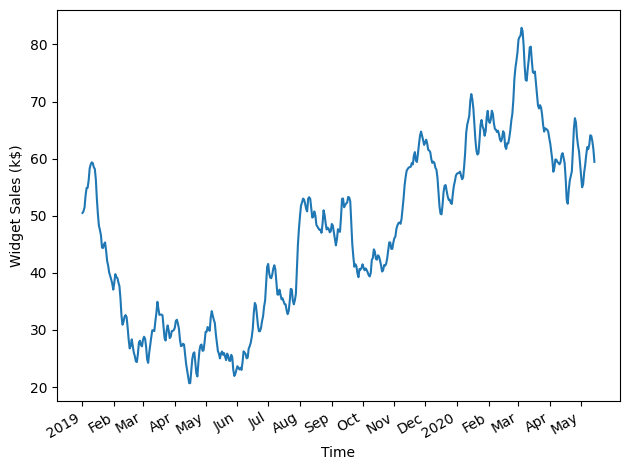

In [93]:
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

fig, ax = plt.subplots()
ax.plot(df['widget_sales'])
ax.set_xlabel('Time')
ax.set_ylabel('Widget Sales (k$)')
ax.set_xticks(ticks, labels)
fig.autofmt_xdate()
plt.tight_layout()

In [94]:
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(df['widget_sales'])
print(f'ADF statistic: {ADF_result[0]:.3f}')
print(f'p-value: {ADF_result[1]:.3f}')

ADF statistic: -1.512
p-value: 0.527


ADF static is not a large negative number, and the p-value is greater than 0.05. Therefore, the time series is not stationary.

In [95]:
import numpy as np

widget_sales_diff = np.diff(df['widget_sales'], n=1)

ADF_result = adfuller(widget_sales_diff)
print(f'ADF statistic: {ADF_result[0]:.3f}')
print(f'p-value: {ADF_result[1]:.3f}')

ADF statistic: -10.577
p-value: 0.000


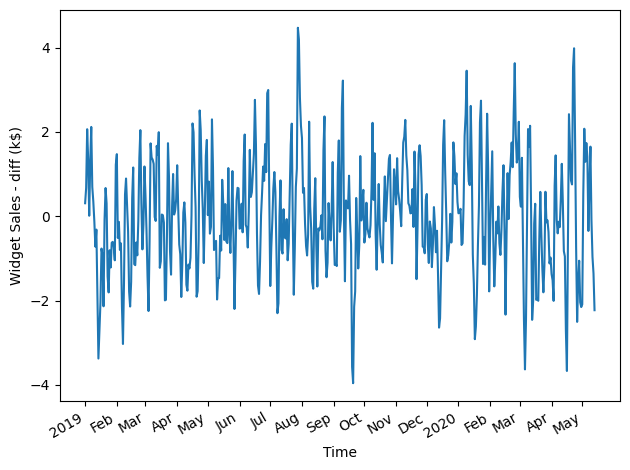

In [96]:
fig, ax = plt.subplots()
ax.plot(widget_sales_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Widget Sales - diff (k$)')
ax.set_xticks(ticks, labels)
fig.autofmt_xdate()
plt.tight_layout()

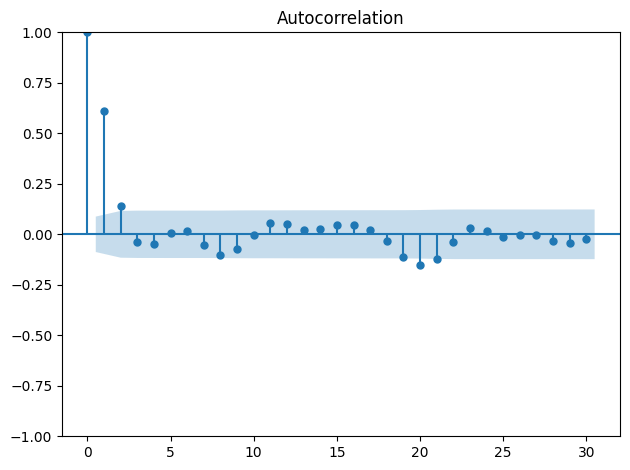

In [97]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(widget_sales_diff, lags=30)

plt.tight_layout()

There are significant autocorrelation coefficients up to lag 2 $\therefore$ we have a MA process of order 2 and we can model it using a $\text{MA}(2)$ model.

In [98]:
df_diff = pd.DataFrame({'widget_sales_diff': widget_sales_diff})
train_test_split = int(0.9*len(df_diff))
train = df_diff.iloc[:train_test_split]
test = df_diff.iloc[train_test_split:]
print(len(train), len(test))

449 50


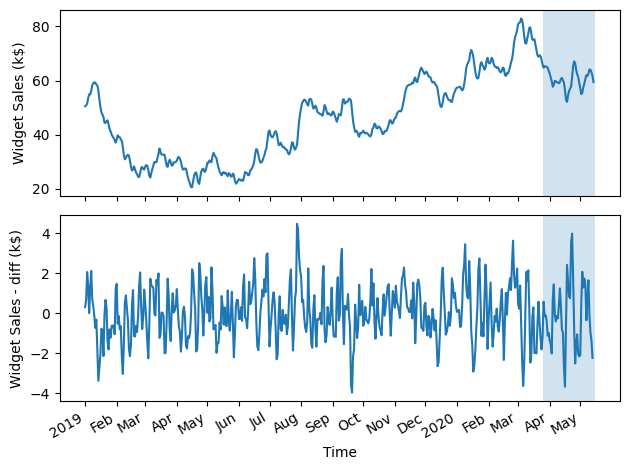

In [99]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)
ax1: Axes; ax2: Axes

ax1.plot(df['widget_sales'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Widget Sales (k$)')
ax1.axvspan(train_test_split, len(df), alpha=0.2)

ax2.plot(df_diff['widget_sales_diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Widget Sales - diff (k$)')
ax2.axvspan(train_test_split, len(df), alpha=0.2)

plt.xticks(ticks, labels)

fig.autofmt_xdate()
fig.tight_layout()

For $\text{MA}(q)$, the current value is dependent on the last $q$ error terms, which are not observed in the dataset, they have to be recursively estimated. $\therefore$ for a $\text{MA}(q)$ model, we can only forecast $q$ steps ahead. Any steps beyond that point will not have past error terms, and the model will only predict the mean.

In [100]:
from typing import Literal

from statsmodels.tsa.statespace.mlemodel import PredictionResults
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults

def rolling_forecast(
    df: pd.DataFrame,
    train_len: int,
    horizon: int,
    window: int, # = q
    method: Literal['mean', 'last', 'MA']
):
    total_len = train_len + horizon
    if method == 'mean':
        pred_mean = []
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
        return pred_mean[:horizon]
    elif method == 'last':
        pred_last_value = []
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
        return pred_last_value[:horizon]
    elif method == 'MA':
        pred_MA = []
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(0,0,window)) # (p,d,q) = (0,0,2) = 2nd-order MA
            res: SARIMAXResults = model.fit(disp=False)
            predictions: PredictionResults = res.get_prediction(0, i+window-1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
        return pred_MA[:horizon]
    
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'MA')

pred_df = test.copy()
pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last
pred_df['pred_MA'] = pred_MA

pred_df.head()

,widget_sales_diff,pred_mean,pred_last_value,pred_MA
449,-1.170131,0.034319,-1.803658,-1.078833
450,0.580967,0.034319,-1.803658,-0.273309
451,-0.144902,0.032861,0.580967,0.781223
452,-0.096564,0.032861,0.580967,0.234969
453,-0.372334,0.032183,-0.096564,0.168994


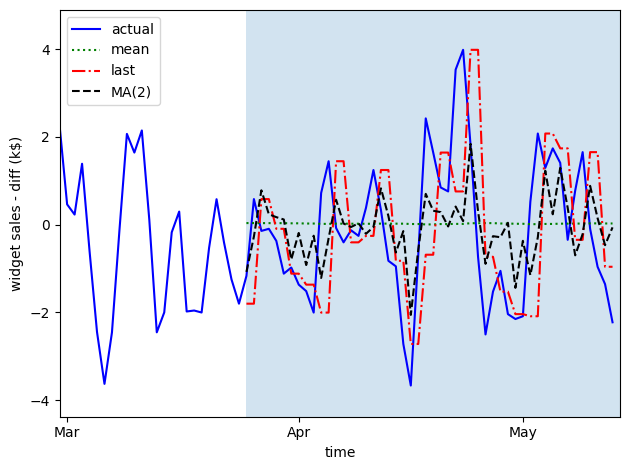

In [101]:
fig, ax = plt.subplots()
ax: Axes

ax.plot(df_diff['widget_sales_diff'], 'b-', label='actual')
ax.plot(pred_df['pred_mean'], 'g:', label='mean')
ax.plot(pred_df['pred_last_value'], 'r-.', label='last')
ax.plot(pred_df['pred_MA'], 'k--', label='MA(2)')

window = int(0.85*len(df_diff))
ax.set_xlim(window, len(df_diff))
ax.set_xlabel('time')
ax.set_ylabel('widget sales - diff (k$)')
ax.axvspan(train_test_split, len(df_diff), alpha=0.2)
ax.set_xticks(ticks[ticks > window], labels[ticks > window])
ax.legend(loc=2)

fig.tight_layout()

In [102]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_mean'])
mse_last_value = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_last_value'])
mse_MA = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_MA'])

for mse, label in zip((mse_mean, mse_last_value, mse_MA), ('mean', 'last', 'MA(2)')):
    print(f'{label}: {mse:.3f}')

mean: 2.561
last: 3.249
MA(2): 1.948


MA(2) is the clear winner. Now we need to inverse-transform our predictions to being them ack to the original scale of the untransformed dataset. To reverse 1st-order difference:

$$
\begin{align}
y_1'=y_1-y_0 &\implies y_1=y_1'+y_0 \\
y_2'=y_2-y_1 &\implies y_2=y_2'+y_1=y_2'+y_1'+y_0 \\
&\vdots \\
y_n'=y_n-y_{n-1} &\implies y_n=y_n'+y_{n-1}=y_0 + \sum_{i=1}^n y_i'
\end{align}
$$

C:\Users\Ben\AppData\Local\Temp\ipykernel_24628\3011852475.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_widget_sales'][train_test_split+1:] = (


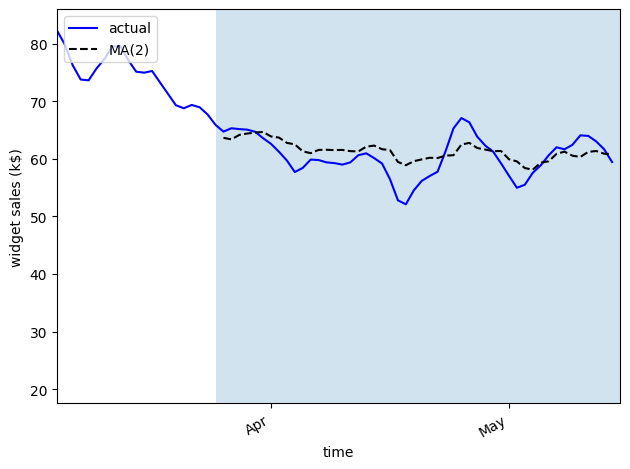

In [103]:
df['pred_widget_sales'] = pd.Series()
df['pred_widget_sales'][train_test_split+1:] = (
    df['widget_sales'].iloc[train_test_split+1] +   # y_0
    pred_df['pred_MA'].cumsum())                    # sum(y_1 ... y_n)

fig, ax = plt.subplots()
ax: Axes

ax.plot(df['widget_sales'], 'b-', label='actual')
ax.plot(df['pred_widget_sales'], 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('time')
ax.set_ylabel('widget sales (k$)')

ax.axvspan(train_test_split, len(df), alpha=0.2)

ax.set_xlim(train_test_split-20, len(df))

ticks, labels = pd.Series(ticks), pd.Series(labels)
ax.set_xticks(ticks[ticks > train_test_split], labels[ticks > train_test_split])

fig.autofmt_xdate()
fig.tight_layout()

In [104]:
from sklearn.metrics import mean_absolute_error

n = train_test_split+1
mae_MA_undiff = mean_absolute_error(df['widget_sales'].iloc[n:], df['pred_widget_sales'].iloc[n:])
print(f'{mae_MA_undiff:.3f} k$')

2.324 k$


# Simulating a $\text{MA}(2)$ process using `ArmaProcess`

We'd like to model the process:

$$
y_t = 0.9 \epsilon_{t-1} + 0.3 \epsilon_{t-2}
$$

Recall that a $\text{MA}(q)$ process is defined by:

$$
y_t=\mu + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \cdots + \theta_q \epsilon_{t-q}
$$

but a $\text{ARMA}(p,q)$ process is defined by:

$$
y_t=\phi_1 y_{t-1} + \cdots + \phi_p y_{t-p} + \epsilon_t + \theta_1 \epsilon_{t-1} + \cdots + \theta_q \epsilon_{t-q}
$$

$\therefore$ a $\text{MA}(q)$ process is just a $\text{ARMA}(0,q)$.

So our original process is a $\text{ARMA}(0,2)$ process with $(\phi_1, \phi_2) = (0.9, 0.3)$.

In [105]:
from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np

np.random.seed(42)

ma2 = np.array([0.9, 0.3])
ar2 = np.array([0, 0])

# both AR and MA components must include coefficient on lag 0
# in ~all cases this should be 0
ma2 = np.r_[1, ma2]
ar2 = np.r_[1, ar2]

MA2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)

MA2_process.shape

(1000,)

In [106]:
a = np.array([1,2,3])
np.r_[1, a]

array([1, 1, 2, 3])

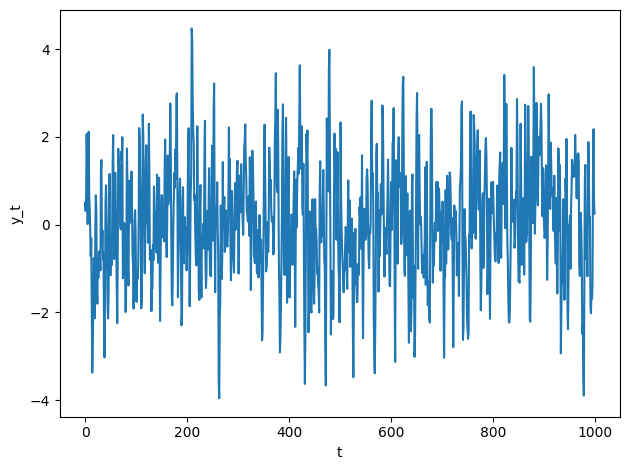

In [107]:
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

fig, ax = plt.subplots()
ax: Axes

ax.plot(MA2_process)
ax.set_xlabel('t')
ax.set_ylabel('y_t')

plt.tight_layout()

In [108]:
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(MA2_process)
print(f'ADF statistic: {ADF_result[0]:.3f}')
print(f'p-value: {ADF_result[1]:.3f}')

ADF statistic: -14.005
p-value: 0.000


The ADF statistic is a large negative number, and the p-value is less than 0.005 $\therefore$ the process is stationary.

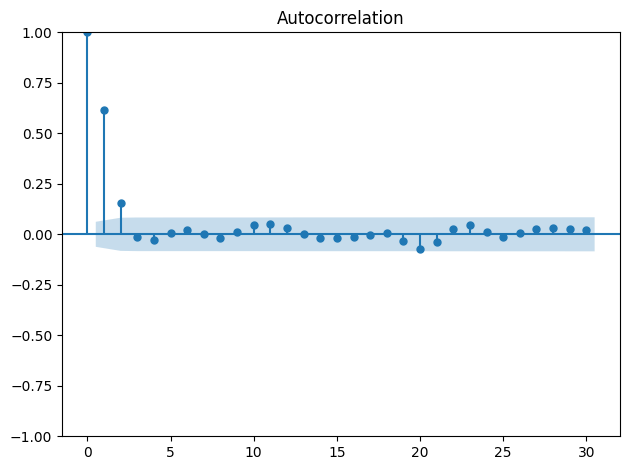

In [109]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(MA2_process, lags=30)
plt.tight_layout()

There are no significant autocorrelation coefficients after lag 2 $\therefore$ we have a $\text{MA}(2)$ process.

In [110]:
import pandas as pd

df = pd.DataFrame({'data': MA2_process})
train_test_split = int(0.8*len(df))
train = df[:train_test_split]
test = df[train_test_split:]

In [111]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'MA')

pred_df = test.copy()
pred_df['pred_mean'] = pred_mean
pred_df['pred_last'] = pred_last
pred_df['pred_MA'] = pred_MA

pred_df.head()

,data,pred_mean,pred_last,pred_MA
800,0.973560,-0.017430,0.259693,0.065366
801,0.337338,-0.017430,0.259693,0.017984
802,-0.086834,-0.015752,0.337338,-0.180397
803,-0.530580,-0.015752,0.337338,-0.116820
804,-0.821708,-0.016481,-0.530580,-0.405768


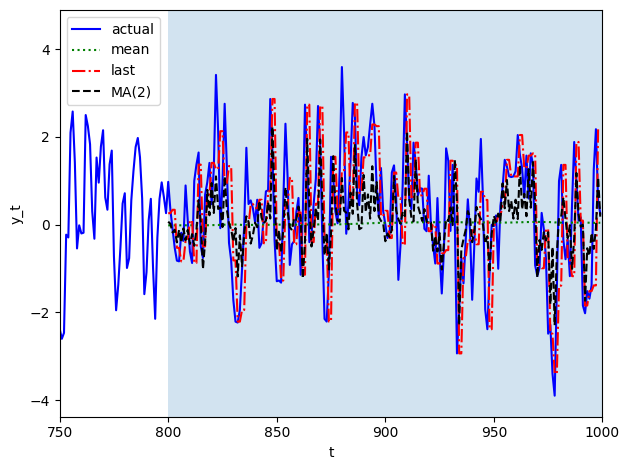

In [112]:
fig, ax = plt.subplots()
ax: Axes

ax.plot(df['data'], 'b-', label='actual')
ax.plot(pred_df['pred_mean'], 'g:', label='mean')
ax.plot(pred_df['pred_last'], 'r-.', label='last')
ax.plot(pred_df['pred_MA'], 'k--', label='MA(2)')

window = int(0.75*len(df))
ax.set_xlim(window, len(df))
ax.set_xlabel('t')
ax.set_ylabel('y_t')
ax.axvspan(train_test_split, len(df), alpha=0.2)
ax.legend(loc=2)

fig.tight_layout()

In [113]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(pred_df['data'], pred_df['pred_mean'])
mse_last_value = mean_squared_error(pred_df['data'], pred_df['pred_last'])
mse_MA = mean_squared_error(pred_df['data'], pred_df['pred_MA'])

for mse, label in zip((mse_mean, mse_last_value, mse_MA), ('mean', 'last', 'MA(2)')):
    print(f'{label}: {mse:.3f}')

mean: 1.864
last: 1.988
MA(2): 1.232


# Simulating a $\text{MA}(q)$ process using `ArmaProcess`

In [114]:
from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np

np.random.seed(42)

nsample = 1000
qs = range(3, 5)

all_data = np.empty((len(qs), nsample))

for q in qs:
    ma = np.random.random(q,)
    ar = np.zeros_like(ma)

    print(ma, ar)

    # both AR and MA components must include coefficient on lag 0
    # in ~all cases this should be 1
    ma = np.r_[1, ma]
    ar = np.r_[1, ar]

    MA_process = ArmaProcess(ar, ma).generate_sample(nsample=nsample)
    all_data[q-min(qs), :] = MA_process

[0.37454012 0.95071431 0.73199394] [0. 0. 0.]
[0.6435777  0.52640266 0.73158952 0.08162998] [0. 0. 0. 0.]


In [115]:
import pandas as pd

train_test_split = int(0.8*nsample)

pred_dfs = {}

for i, q in enumerate(qs):
    data = all_data[i, :]
    df = pd.DataFrame({'data': data})
    train = df[:train_test_split]
    test = df[train_test_split:]
    
    # we're assuming the data is stationary
    
    pred_mean = rolling_forecast(df, len(train), len(test), q, 'mean')
    pred_last = rolling_forecast(df, len(train), len(test), q, 'last')
    pred_MA = rolling_forecast(df, len(train), len(test), q, 'MA')

    pred_dfs[(q, 'data')] = test['data']
    pred_dfs[(q, 'pred_mean')] = pred_mean
    pred_dfs[(q, 'pred_last')] = pred_last
    pred_dfs[(q, 'pred_MA')] = pred_MA
    
pred_dfs = pd.DataFrame(pred_dfs)

In [116]:
pred_dfs

3                                       4                      \
         data pred_mean pred_last   pred_MA      data pred_mean pred_last   
800 -0.995756  0.099519 -2.429968 -2.451823 -1.599870 -0.016174 -3.292476   
801 -2.076994  0.099519 -2.429968 -2.690962 -1.685700 -0.016174 -3.292476   
802 -2.508494  0.099519 -2.429968 -1.677655 -0.378899 -0.016174 -3.292476   
803 -1.416807  0.092197 -2.508494  0.004350  2.389187 -0.016174 -3.292476   
804 -2.900482  0.092197 -2.508494 -1.371135  2.248263 -0.017680  2.389187   
..        ...       ...       ...       ...       ...       ...       ...   
995  1.807704  0.057229  0.311646  0.399896 -0.937201 -0.016906  0.845746   
996  0.470321  0.057229  0.311646 -0.240158 -0.376831 -0.018200 -0.937201   
997  1.604217  0.057229  0.311646 -0.425541 -1.071369 -0.018200 -0.937201   
998  1.063952  0.060947  1.604217  1.328522 -1.819219 -0.018200 -0.937201   
999  2.230291  0.060947  1.604217  0.756453  0.198414 -0.018200 -0.937201   

               
      pred_MA  
800 -2.312947  
801 -1.900717  
802 -1.351719  
803 -0.039309  
804  1.186263  
..        ...  
995  0.025354  
996 -0.454704  
997 -1.129301  
998 -0.165302  
999 -0.005568  

[200 rows x 8 columns]

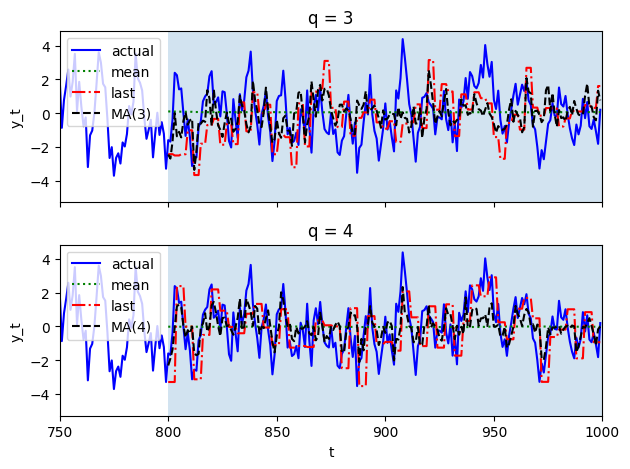

In [117]:
fig, axs = plt.subplots(nrows=len(qs), ncols=1, sharex=True)
axs: list[Axes]

for i, q in enumerate(qs):
    pred_df = pred_dfs[q]
    ax = axs[i]
    ax.set_title(f'q = {q}')
    ax.plot(df['data'], 'b-', label='actual')
    ax.plot(pred_df['pred_mean'], 'g:', label='mean')
    ax.plot(pred_df['pred_last'], 'r-.', label='last')
    ax.plot(pred_df['pred_MA'], 'k--', label=f'MA({q})')
    ax.axvspan(train_test_split, nsample, alpha=0.2)
    ax.set_ylabel('y_t')
    ax.legend(loc=2)

window = int(0.75*nsample)
plt.xlim(window, nsample)
plt.xlabel('t')
fig.tight_layout()

In [118]:
from sklearn.metrics import mean_squared_error

for q in qs:
    pred_df = pred_dfs[q]
    
    mse_mean = mean_squared_error(pred_df['data'], pred_df['pred_mean'])
    mse_last_value = mean_squared_error(pred_df['data'], pred_df['pred_last'])
    mse_MA = mean_squared_error(pred_df['data'], pred_df['pred_MA'])

    print(f'q = {q}')
    for mse, label in zip((mse_mean, mse_last_value, mse_MA), ('mean', 'last', f'MA({q})')):
        print(f'{label}: {mse:.3f}')
    print()

q = 3
mean: 2.274
last: 2.452
MA(3): 1.414

q = 4
mean: 2.297
last: 2.728
MA(4): 1.490

